In [2]:
options(java.parameters = "-Xmx8000m") 
# more RAM for java, for writing xls. Done before loading the library

In [4]:
# loading libraries:
library("ggplot2") # for volcano plot
library("ggrepel") # for text labels that don't overlap (volcano plot)
library("xlsx") # to save xls file
library("DESeq2") # for rlog data
library("gridExtra") # several ggplots in one pdf
library("circlize") # colorRamp2

In [5]:
setwd("..") # change to main directory

In [6]:
padjCutoff = 0.05
outDir = "Figures-and-Tables/"
geneAnnotFile = "annotation/Homo_sapiens.GRCh37.75-chrRename-noHaplo.RData"
geneAnnotHandCuratedFile = "annotation/signif-regions-hand-curated-annotation.txt"
sampleAnnotFile = "annotation/annotation-63.csv"
featureCountFile= "data/expressedTiles-featureCounts-25M10percIDS-min5reads20percent.RData"
deseqComparisons = list(group = c("urolithiasis","ccRCC"))
deseqResFile =  paste0(outDir,"DGE-results.RData") # will bre produced
resFile = paste0(outDir,"SupplTable-S4-diff-genex-results.xlsx") # will bre produced
volcanoPlotFile = paste0(outDir,"Figure-3-volcano-plot.png") # will bre produced
minReadCountSum = 0
minReadCountPerSample = 0
adjustVars <- c("gender","age")

In [7]:
# load sample annotation:
sampleAnnot = read.csv(file = sampleAnnotFile,sep = "\t", dec=".", stringsAsFactors = F )
sampleAnnot$gender = ifelse(sampleAnnot$gender=="f","female","male")
rownames(sampleAnnot) = sampleAnnot$ID
head(sampleAnnot,3)

,ID,gender,age,group
,<chr>,<chr>,<int>,<chr>
SXR0002,SXR0002,female,80,ccRCC
SXR0004,SXR0004,male,50,ccRCC
SXR0006,SXR0006,male,68,ccRCC


In [8]:
# convert string variables to factors:
sampleAnnot$group = factor(sampleAnnot$group, levels = c("urolithiasis","ccRCC")) # uro is base level
head(sampleAnnot,3)

,ID,gender,age,group
,<chr>,<chr>,<int>,<fct>
SXR0002,SXR0002,female,80,ccRCC
SXR0004,SXR0004,male,50,ccRCC
SXR0006,SXR0006,male,68,ccRCC


In [9]:
load(file = featureCountFile)
counts <- as.matrix(fcountGenes$counts)
head(counts,3)
dim(counts)

,SXR0002,SXR0004,SXR0006,SXR0010,SXR0014,SXR0016,SXR0018,SXR0028,SXR0029,SXR0030,⋯,SXR0105,SXR0111,SXR0112,SXR0113,SXR0114,SXR0115,SXR0117,SXR0118,SXR0121,SXR0122
chr1_1337301_1337400,0,0,3,3,10,1,6,14,7,6,⋯,9,19,23,9,0,0,5,0,8,19
chr1_1477001_1477100,0,1,3,2,7,2,4,0,3,4,⋯,3,5,3,4,0,0,2,0,3,3
chr1_1477101_1477200,0,0,0,0,2,0,7,0,4,3,⋯,2,10,5,3,3,0,3,0,2,5


[1] 6242   63

### map region coordinates to genes

In [11]:
rn = rownames(counts)
regionsCoord <- data.frame(
    chr = gsub("(chr[^_]+).+","\\1",rn),
    start = as.numeric(gsub("chr[^_]+_([^_]+).+","\\1",rn)),
    end = as.numeric(gsub("chr[^_]+_[^_]+_([^_]+)","\\1",rn))
)
head(regionsCoord,3)

,chr,start,end
,<chr>,<dbl>,<dbl>
1,chr1,1337301,1337400
2,chr1,1477001,1477100
3,chr1,1477101,1477200


In [12]:
# gene annotation:
load(geneAnnotFile)
geneAnnot = geneAnnot[which(geneAnnot$V3=="gene"),]
geneAnnot$EnsID = gsub(".*gene_id ([^;]+).*","\\1",geneAnnot$V9)
geneAnnot$type = gsub(".*gene_biotype ([^;]+).*","\\1",geneAnnot$V9)
geneAnnot$symbol = gsub(".*gene_name ([^;]+).*","\\1",geneAnnot$V9)
head(geneAnnot$symbol)
geneAnnotGR = GRanges(seqnames = geneAnnot$V1,
                  ranges = IRanges(start = geneAnnot$V4,end = geneAnnot$V5))

[1] "DDX11L1"    "WASH7P"     "MIR1302-10" "FAM138A"    "OR4G4P"    
[6] "OR4G11P"

In [13]:
# annotate regions:
regionsGR = GRanges(seqnames = regionsCoord$chr, 
                ranges = IRanges(start = regionsCoord$start, end = regionsCoord$end) )
# overlapping gene annot
ovlp = as.data.frame(findOverlaps(query = geneAnnotGR,subject = regionsGR))

regionAnnot = data.frame(name=rownames(counts),regionsCoord)
head(regionAnnot,3)

# add gene symbols and annot:
regionIdx <- unique(ovlp$subjectHits)
for(r in regionIdx) {
  regionAnnot$gene[r] = paste0(
      geneAnnot$symbol[ovlp$queryHits[ovlp$subjectHits == r]],collapse=";")
  regionAnnot$EnsgID[r] = paste0(
      geneAnnot$EnsID[ovlp$queryHits[ovlp$subjectHits == r]],collapse=";")
  regionAnnot$geneType[r] = paste0(
      geneAnnot$type[ovlp$queryHits[ovlp$subjectHits == r]],collapse=";")
}
rownames(regionAnnot) = regionAnnot$name
head(regionAnnot,2)

,name,chr,start,end
,<chr>,<chr>,<dbl>,<dbl>
1,chr1_1337301_1337400,chr1,1337301,1337400
2,chr1_1477001_1477100,chr1,1477001,1477100
3,chr1_1477101_1477200,chr1,1477101,1477200


,name,chr,start,end,gene,EnsgID,geneType
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1_1337301_1337400,chr1_1337301_1337400,chr1,1337301,1337400,RP4-758J18.2;MRPL20,ENSG00000224870;ENSG00000242485,protein_coding;protein_coding
chr1_1477001_1477100,chr1_1477001_1477100,chr1,1477001,1477100,SSU72,ENSG00000160075,protein_coding


In [14]:
geneLength = 100
TPMs = counts
TPMs[,names(totalReads)] <- sapply(names(totalReads),function(x) TPMs[,x]/(geneLength/10^3) )
head(TPMs[,1:4],2)
TPMsums <- colSums(TPMs)
TPMs[,names(totalReads)] <- sapply(names(TPMsums),function(x) TPMs[,x]/(TPMsums[x]/10^6))
head(counts[,1:4],2)
head(TPMs[,1:4],2)

,SXR0002,SXR0004,SXR0006,SXR0010
chr1_1337301_1337400,0,0,30,30
chr1_1477001_1477100,0,10,30,20


,SXR0002,SXR0004,SXR0006,SXR0010
chr1_1337301_1337400,0,0,3,3
chr1_1477001_1477100,0,1,3,2


,SXR0002,SXR0004,SXR0006,SXR0010
chr1_1337301_1337400,0,0.000000,43.5262,16.14683
chr1_1477001_1477100,0,4.154791,43.5262,10.76455


## DESeq2

In [15]:
modelFormula <- as.formula("~ gender + age + group")
modelFormula
dds = DESeqDataSetFromMatrix( 
    countData = counts,colData = sampleAnnot, design = modelFormula)

~gender + age + group

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  Including numeric variables with large mean can induce collinearity with the intercept.
  Users should center and scale numeric variables in the design to improve GLM convergence.



In [16]:
# remove genes with 0 or 1 counts for all samples:
dds = dds[ rowSums( counts(dds) ) >= minReadCountSum , ]
dds = dds[ which(rowMin(counts(dds)) >= minReadCountPerSample), ]

In [17]:
# differential gene expression:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [18]:
deseqRes <- as.data.frame(results(dds))
head(deseqRes,2)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1_1337301_1337400,5.321137,0.72024068,0.3769959,1.9104736,0.05607226,0.3582932
chr1_1477001_1477100,2.184467,-0.08014081,0.3619441,-0.2214176,0.82476727,NA


In [19]:
# add regions' gene annotation and
#  read counts sorted by group and then alphabetically by id:
idSorted = sampleAnnot$ID[ order(-as.numeric(sampleAnnot$group), sampleAnnot$ID)]
deseqRes = cbind(regionAnnot[ rownames(deseqRes),-1], 
                 deseqRes, 
                 as.data.frame(assay(dds))[rownames(deseqRes),idSorted])
# remove chrY:
deseqRes = deseqRes[ which(deseqRes$chr != "chrY"),]

In [20]:
# add hand curated gene annotation (from UCSC inspection)
tmp = read.csv(file=geneAnnotHandCuratedFile, stringsAsFactors=F, sep="\t")
geneAnnotCurated = tmp$hand_curated_annotation
names(geneAnnotCurated) = tmp$coordinates
geneAnnotCurated

chr1_28905201_28905300 chr1_153643701_153643800 chr1_153643801_153643900 
               "SNORD99"               "TRNA_Met"                       "" 
chr3_186504601_186504700   chr6_86387301_86387400  chr11_62609001_62609100 
               "SNORA81"               "SNORD50B"                "RNU2-2P" 
 chr11_62609101_62609200  chr11_62620301_62620400  chr11_62620401_62620500 
               "RNU2-2P"                "SNORD22"                "SNORD22" 
 chr11_62622701_62622800  chr11_62622801_62622900  chr11_65267201_65267300 
               "SNORD26"                "SNORD26"                "mascRNA" 
 chr17_62223801_62223900 
               "SNORA76"

In [21]:
deseqRes[ names(geneAnnotCurated), "gene" ] = unname(geneAnnotCurated)
deseqRes[ which(deseqRes$padj < 0.05),c("gene","log2FoldChange","padj")]

,gene,log2FoldChange,padj
,<chr>,<dbl>,<dbl>
chr1_28905201_28905300,SNORD99,-3.450529,0.0008962246
chr1_153643701_153643800,TRNA_Met,-1.632384,0.0118502833
chr1_153643801_153643900,,-2.187097,0.0255807835
chr3_186504601_186504700,SNORA81,-1.799555,0.0165430630
chr6_86387301_86387400,SNORD50B,-2.178942,0.0439096075
chr11_62609001_62609100,RNU2-2P,-2.188605,0.0439096075
chr11_62609101_62609200,RNU2-2P,-1.734527,0.0255807835
chr11_62620301_62620400,SNORD22,-2.939119,0.0192698592
chr11_62620401_62620500,SNORD22,-2.269205,0.0033185135


In [22]:
# TPMs
deseqResTPM = deseqRes
deseqResTPM[,sampleAnnot$ID] <- TPMs[rownames(deseqRes),sampleAnnot$ID,drop=F]

# rlog TPMs:
rld = assay(rlog(dds))
deseqResTPMrlog = deseqRes
deseqResTPMrlog[,sampleAnnot$ID] = rld[rownames(deseqRes),sampleAnnot$ID,drop=F]

rlog() may take a long time with 50 or more samples,
vst() is a much faster transformation

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



In [23]:
head(deseqResTPM,2)
head(deseqResTPMrlog,2)

,chr,start,end,gene,EnsgID,geneType,baseMean,log2FoldChange,lfcSE,stat,⋯,SXR0049,SXR0060,SXR0070,SXR0071,SXR0084,SXR0098,SXR0117,SXR0118,SXR0121,SXR0122
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1_1337301_1337400,chr1,1337301,1337400,RP4-758J18.2;MRPL20,ENSG00000224870;ENSG00000242485,protein_coding;protein_coding,5.321137,0.72024068,0.3769959,1.9104736,⋯,7.410353,2.935504,15.99107,13.74533,3.882281,32.013659,14.280532,0,22.132157,14.901552
chr1_1477001_1477100,chr1,1477001,1477100,SSU72,ENSG00000160075,protein_coding,2.184467,-0.08014081,0.3619441,-0.2214176,⋯,4.940236,2.935504,19.54465,0.00000,3.882281,8.536976,5.712213,0,8.299559,2.352877


,chr,start,end,gene,EnsgID,geneType,baseMean,log2FoldChange,lfcSE,stat,⋯,SXR0049,SXR0060,SXR0070,SXR0071,SXR0084,SXR0098,SXR0117,SXR0118,SXR0121,SXR0122
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1_1337301_1337400,chr1,1337301,1337400,RP4-758J18.2;MRPL20,ENSG00000224870;ENSG00000242485,protein_coding;protein_coding,5.321137,0.72024068,0.3769959,1.9104736,⋯,1.3064298,0.7548236,1.904516,2.109244,1.070711,2.6399175,2.0350024,2.022047,2.2573249,2.15817906
chr1_1477001_1477100,chr1,1477001,1477100,SSU72,ENSG00000160075,protein_coding,2.184467,-0.08014081,0.3619441,-0.2214176,⋯,0.5282031,0.1839688,1.803015,0.498729,0.580836,0.9563862,0.7986319,1.310339,0.9357352,0.06520687


In [24]:
# add mean, median, sd for all samples and for each group:
for (groupName in c("ccRCC","urolithiasis")) {
    samples = sampleAnnot$ID[ sampleAnnot$group == groupName]
    deseqRes[,paste0(groupName,"_mean")] = rowMeans(deseqRes[,samples,drop=F])
    deseqRes[,paste0(groupName,"_median")] = apply(deseqRes[,samples,drop=F],1,median)
    deseqRes[,paste0(groupName,"_sd")] = apply(deseqRes[,samples,drop=F],1,sd)
    deseqResTPM[,paste0(groupName,"_mean")] = rowMeans(deseqResTPM[,samples,drop=F])
    deseqResTPM[,paste0(groupName,"_median")] = apply(deseqResTPM[,samples,drop=F],1,median)
    deseqResTPM[,paste0(groupName,"_sd")] = apply(deseqResTPM[,samples,drop=F],1,sd)
    deseqResTPMrlog[,paste0(groupName,"_mean")] = rowMeans(deseqResTPMrlog[,samples,drop=F])
    deseqResTPMrlog[,paste0(groupName,"_median")] = apply(deseqResTPMrlog[,samples,drop=F],1,median)
    deseqResTPMrlog[,paste0(groupName,"_sd")] = apply(deseqResTPMrlog[,samples,drop=F],1,sd)
}
deseqRes[,"all_mean"] = rowMeans(deseqRes[,sampleAnnot$ID,drop=F])
deseqRes[,"all_median"] = apply(deseqRes[,sampleAnnot$ID,drop=F],1,median)
deseqRes[,"all_sd"] = apply(deseqRes[,sampleAnnot$ID,drop=F],1,sd)
deseqResTPM[,"all_mean"] = rowMeans(deseqResTPM[,sampleAnnot$ID,drop=F])
deseqResTPM[,"all_median"] = apply(deseqResTPM[,sampleAnnot$ID,drop=F],1,median)
deseqResTPM[,"all_sd"] = apply(deseqResTPM[,sampleAnnot$ID,drop=F],1,sd)
deseqResTPMrlog[,"all_mean"] = rowMeans(deseqResTPMrlog[,sampleAnnot$ID,drop=F])
deseqResTPMrlog[,"all_median"] = apply(deseqResTPMrlog[,sampleAnnot$ID,drop=F],1,median)
deseqResTPMrlog[,"all_sd"] = apply(deseqResTPMrlog[,sampleAnnot$ID,drop=F],1,sd)

In [25]:
# sort columns:
whStats = grep("_mean|_median|_sd",colnames(deseqRes))
whExpr = which(colnames(deseqRes) %in% sampleAnnot$ID)
whRest = setdiff(1:ncol(deseqRes),c(whStats,whExpr))
cn = colnames(deseqRes[,c(whRest,whStats,whExpr)])
deseqRes = deseqRes[,cn]
deseqResTPM = deseqResTPM[,cn]
deseqResTPMrlog = deseqResTPMrlog[,cn]

In [26]:
# save results to file:

# header for each sample column indicating the group (urolithiasis/ccRCC)
header <- rep("",ncol(deseqRes))
wh <- which(colnames(deseqRes) %in% sampleAnnot$ID)
header[wh] <-  as.character(sampleAnnot[colnames(deseqRes)[wh],"group"])

In [27]:
head(rbind(header,deseqRes),3)

,chr,start,end,gene,EnsgID,geneType,baseMean,log2FoldChange,lfcSE,stat,⋯,SXR0049,SXR0060,SXR0070,SXR0071,SXR0084,SXR0098,SXR0117,SXR0118,SXR0121,SXR0122
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,,,,,,,,,,⋯,urolithiasis,urolithiasis,urolithiasis,urolithiasis,urolithiasis,urolithiasis,urolithiasis,urolithiasis,urolithiasis,urolithiasis
chr1_1337301_1337400,chr1,1337301,1337400,RP4-758J18.2;MRPL20,ENSG00000224870;ENSG00000242485,protein_coding;protein_coding,5.32113710504829,0.720240682741623,0.376995880533365,1.91047361505023,⋯,3,1,9,1,2,15,5,0,8,19
chr1_1477001_1477100,chr1,1477001,1477100,SSU72,ENSG00000160075,protein_coding,2.18446669827313,-0.0801408123860691,0.361944137081133,-0.221417628235003,⋯,2,1,11,0,2,4,2,0,3,3


In [28]:
whStats = grep("_mean|_median|_sd",colnames(deseqRes))
whExpr = which(colnames(deseqRes) %in% sampleAnnot$ID)

In [29]:
out = deseqRes
out = apply(out,2,as.character)
out = rbind(header,colnames(out),out) 
write.xlsx2(x = out, file = resFile, sheetName = "DGE - counts", 
            row.names = F, col.names = F, append = F )

In [30]:
out = deseqResTPM
out[,c(whStats,whExpr)] = round(out[,c(whStats,whExpr)],2)
out = apply(out,2,as.character)
out = rbind(header,colnames(out),out) 
write.xlsx2(x = out, file = resFile, sheetName = "DGE - TPM", 
            row.names = F, col.names = F, append = T )

In [31]:
out = deseqResTPMrlog
out[,c(whStats,whExpr)] = round(out[,c(whStats,whExpr)],2)
out = apply(out,2,as.character)
out = rbind(header,colnames(out),out) 
write.xlsx2(x = out, file = resFile, sheetName = "DGE - rlog(TPM)", 
            row.names = F, col.names = F, append = T )

In [32]:
deseqRes_signif = deseqRes[ which(deseqRes$padj < 0.05), ]

In [33]:
# save as RData for later
save(deseqRes_signif, file = deseqResFile)

Warning message:
“Removed 10 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3032 rows containing missing values (`geom_text_repel()`).”
Warning message:
“Removed 10 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 3032 rows containing missing values (`geom_text_repel()`).”


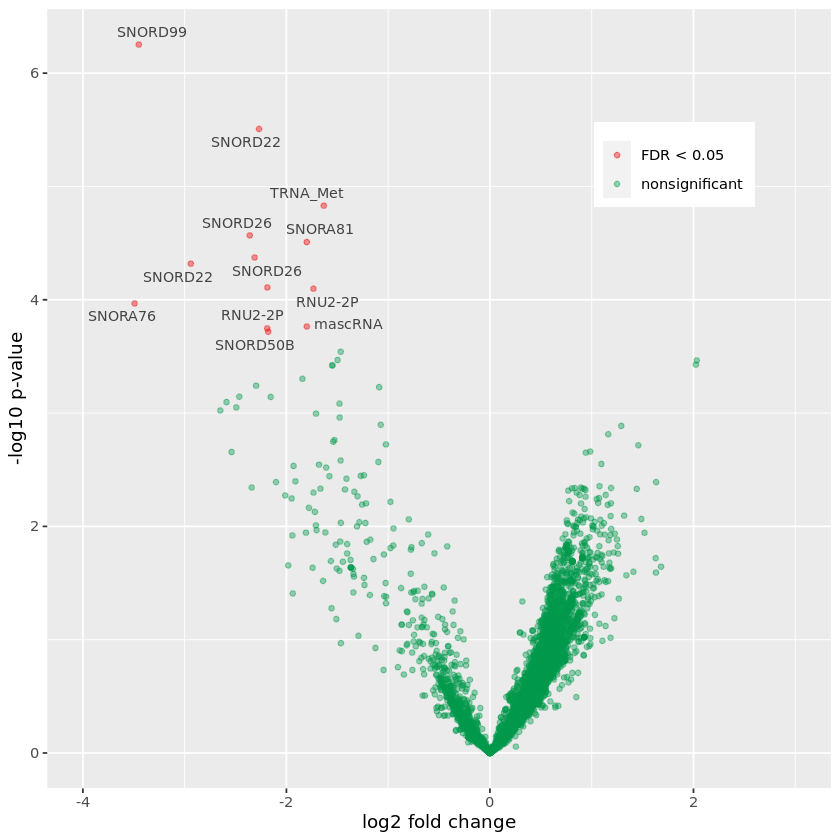

In [34]:
# volcano plot

exponents <- -log10(deseqRes$pvalue) 
maxEpo <- max(exponents[exponents!=Inf])
deseqRes$threshold <- ifelse( is.na(deseqRes$padj) | deseqRes$padj > padjCutoff,"nonsignificant","FDR < 0.05")
cols <- c("FDR < 0.05" = "red2", "nonsignificant" = "#00994d")

g <- ggplot(data=deseqRes, aes(x=log2FoldChange, y=-log10(pvalue), colour=threshold)) +
  geom_point(alpha=0.4, size=1.25) +
  scale_color_manual(name=NULL, values=cols)+#, labels = c("FDR < 0.05", "nonsignificant"))+
  xlim(c(-4, 3)) + ylim(c(0, maxEpo)) +
  xlab("log2 fold change") + ylab("-log10 p-value") +
  geom_text_repel(data = deseqRes[ deseqRes$padj<0.05,],mapping = aes(label=gene), size=3,color="#444444" )  + 
  theme(legend.position = c(0.8, 0.8))

g
ggsave(filename = volcanoPlotFile,width = 7, height=7,dpi = 150)